# Combine multiple QSVR trained with small data

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
from qa_summer.QSVR import QSVR
from dimod import ExactSolver
from sklearn.preprocessing import QuantileTransformer
from sklearn.model_selection import train_test_split
from utils import nb_utils
from joblib import dump, load
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import datetime
from random import randint, random
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVR
import neal #import to use simulated annealing sampler
from dwave.system import LazyFixedEmbeddingComposite, DWaveSampler #import to select specific sampler

In [40]:
experiment_name = 'combinations'
save = True
num_splits = 10
train_size = 80 # divisible by 20
#date = datetime.datetime.now().strftime("_%Y_%m_%d-%I:%M:%S.%f_%p")
#experiment_name = experiment_name + date

In [41]:
#load and scale data
# load data
df_info = nb_utils.get_df_info('mlpf')
df = pd.read_csv(df_info['df_path'])
df = df.drop(df[df.loss_99 == df.loss_99.max()].index)

# Select features
curve = nb_utils.get_curve(df_info=df_info, known_curve=0.25, df=df)
X = curve[:,[i for i in range(0,curve.shape[1],2)]]

# Prediction target
y = nb_utils.get_target(df_info,df)

# Scale data
x_scaler = QuantileTransformer(n_quantiles=50,random_state=0)
X = x_scaler.fit_transform(X)
y_scaler =  QuantileTransformer(n_quantiles=50,random_state=0)
y = y_scaler.fit_transform(y.reshape(-1, 1)).ravel()

In [42]:
'''
WARNING: THIS CELL SENDS PROBLEMS TO D-WAVE MULTIPLE TIMES
REMEMBRER D-WAVE AVALIABLE TIME IS LIMITED
'''
rs = randint(0, 2**30)
all_r2 = np.zeros(num_splits)
all_preds = []
model = QSVR.QSVR() # instantiate Moved outside the loop so that sub-QSVRs that will be combined can use the same embedding saving local time
for i in range(num_splits):
	# train test split
	X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=rs+i)
	X_train, y_train = X_train[:train_size], y_train[:train_size]

	# split the training set in subsets of 20 elements an use each one to train a different
	total = int(train_size/20)
	y_preds = []
	weights = np.zeros(total)
	for j in range(total):
		X_train_j, y_train_j = X_train[20*j:20*(j+1)], y_train[20*j:20*(j+1)]
		#model = QSVR.QSVR() # instantiate Moved outside the loop so that sub-QSVRs that will be combined can use the same embedding saving local time
		#RUN ON D-WAVE
		#set sampler
		#sampler = LazyFixedEmbeddingComposite(DWaveSampler(region='na-west-1', solver='Advantage_system6.1'))
		#sampler = neal.SimulatedAnnealingSampler() #Simulated sampler doesnt use quantum time
		model.fit(X_train_j, y_train_j,
			K = 3, B = 0.5,
			epsilon = 0.02, k0 = 0.005,
			xi=0.01, n_samples = 20,
			#num_reads = 5000,
			num_reads=1000,
			random_seed=rs+i+j,
			n_samples_for_gamma_and_C_optimizations=0,
			gamma=0.1, C=67.61,
			use_custom_chainstrength=True,
			chain_mult=10
			#anneal_time=40,
			#sampler = sampler
		)
		if save: nb_utils.save_qsvr(model, 'qsvr_attrs_'+experiment_name+'_rs'+str(rs)+'_i'+str(i)+'_j'+str(j)) # save QSVR for further predictions
		remove = [x for x in range(20*j,20*(j+1))]
		X_partial_test, y_partial_test = np.delete(X_train, remove, 0), np.delete(y_train, remove, 0)
		y_partial_pred = model.predict(X_partial_test)
		partial_r2 = np.zeros(y_partial_pred.shape[0])
		for k in range(y_partial_pred.shape[0]):
			partial_r2[k] = r2_score(y_partial_pred[k],y_partial_test)
		weights[j]=partial_r2.max()
		if weights[j] < 0: weights[j] = 0 
		method = partial_r2.argmax()
		y_preds.append(model.predict(X_test)[method])
		
	#combine predictions
	y_pred = np.zeros(y_test.shape[0])
	for k in range(total):
		y_pred = y_pred + weights[k]*y_preds[k]
	y_pred = y_pred / weights.sum()
	all_preds.append(np.array(y_pred))
	all_r2[i] = r2_score(y_pred,y_test)

In [35]:
# Save the results
if save:
    dump(all_r2, 'all_r2'+experiment_name+'_rs'+str(rs)+'joblib')
    dump(all_preds,'all_preds'+experiment_name+'_rs'+str(rs)+'joblib')

## Analize results 

In [36]:
# uncomment following line(s) if you want to analize results of a saved experiment
#results = load('../results/good_qsvr/chain_str_10/results_eric_params_chain_10_hp_search_rs965737426.joblib')
#rs = 965737426

### R^2 summary

In [39]:
print(f'All r2 metrics:\nmean = {all_r2.mean()} \nmax = {all_r2.max()} \nmin = {all_r2.min()} \nmedian = {np.median(all_r2)} \nstd = {all_r2.std()}')
# print(all_r2)

All r2 metrics:
mean = 0.8992181407218812 
max = 0.9265883056342518 
min = 0.8566858668226855 
median = 0.897392889798428 
std = 0.019158684593577717


### True vs Predicted loss for the Combined QSVR split with best R^2

0.9265883056342518


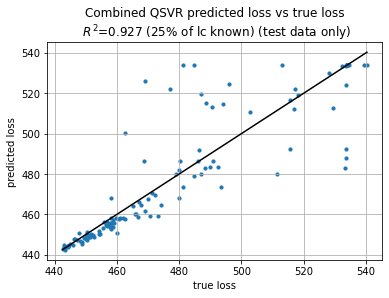

In [37]:
best_pred = all_preds[all_r2.argmax()]
_, _, _, y_test = train_test_split(X, y, test_size=0.5, random_state=rs+all_r2.argmax())
print(r2_score(best_pred,y_test))
x_plot = y_scaler.inverse_transform(y_test.reshape(-1, 1))
y_plot = y_scaler.inverse_transform(best_pred.reshape(-1, 1))

plt.scatter(x_plot,y_plot,s=10)
plt.plot([x_plot.min(),x_plot.max()],[x_plot.min(),x_plot.max()],'k')

plt.xlabel("true loss")
plt.ylabel("predicted loss")
plt.grid()
plt.title("Combined QSVR predicted loss vs true loss\n $R^2$="+"{:.3f}".format(r2_score(best_pred,y_test))+" (25% of lc known) (test data only)")
plt.savefig("../results/mlpf_combined_qsvr.png",dpi=300)
plt.show()
